<a href="https://colab.research.google.com/github/Lohithvennapureddy/PRODIGY_ML_04/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle

from google.colab import files
print("Upload your kaggle.json (from your Kaggle account -> Account -> Create API token).")
uploaded = files.upload()  # choose kaggle.json


import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open('kaggle.json','wb') as f:
  f.write(uploaded['kaggle.json'])
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gti-upm/leapgestrecog -q --unzip


!ls -lah


Upload your kaggle.json (from your Kaggle account -> Account -> Create API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
total 32K
drwxr-xr-x  1 root root 4.0K Oct 30 17:07 .
drwxr-xr-x  1 root root 4.0K Oct 30 17:02 ..
drwxr-xr-x  4 root root 4.0K Oct 28 13:34 .config
drwxr-xr-x  2 root root 4.0K Oct 30 17:05 .ipynb_checkpoints
-rw-r--r--  1 root root   74 Oct 30 17:05 kaggle.json
drwxr-xr-x  3 root root 4.0K Oct 30 17:07 leapgestrecog
drwxr-xr-x 12 root root 4.0K Oct 30 17:07 leapGestRecog
drwxr-xr-x  1 root root 4.0K Oct 28 13:34 sample_data


In [3]:
import os, glob
from PIL import Image
print("Sample folders/files:")
for root, dirs, files in os.walk('.', topdown=True):
    if 'leapgestrecog' in root or 'dataset' in root or 'LeapGestRecog' in root:
        print(root)
        break

# If images are in a folder, show counts per class (assuming dataset layout centers around images named by class or in class folders)
from collections import Counter
img_paths = glob.glob('**/*.png', recursive=True) + glob.glob('**/*.jpg', recursive=True)
print("Total images found:", len(img_paths))
# show first few
img_paths[:8]


Sample folders/files:
./leapgestrecog
Total images found: 40000


['leapGestRecog/01/01_palm/frame_01_01_0013.png',
 'leapGestRecog/01/01_palm/frame_01_01_0137.png',
 'leapGestRecog/01/01_palm/frame_01_01_0085.png',
 'leapGestRecog/01/01_palm/frame_01_01_0061.png',
 'leapGestRecog/01/01_palm/frame_01_01_0008.png',
 'leapGestRecog/01/01_palm/frame_01_01_0151.png',
 'leapGestRecog/01/01_palm/frame_01_01_0190.png',
 'leapGestRecog/01/01_palm/frame_01_01_0171.png']

In [6]:
from pathlib import Path
import random, os
from PIL import Image, ImageOps

ROOT = Path("leapGestRecog")  # top folder after unzip

# Find actual gesture folders (10 gesture names like 00_palm, 01_l, etc.)
gesture_dirs = []
for user_dir in ROOT.iterdir():
    if user_dir.is_dir():
        for gesture_dir in user_dir.iterdir():
            if gesture_dir.is_dir():
                gesture_dirs.append(gesture_dir)

# Get gesture class names (unique)
classes = sorted({p.name for p in gesture_dirs})
print("Detected gesture classes:", classes)

# Create output folders
OUT = Path("processed_data")
for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(OUT / split / cls, exist_ok=True)

# Simple preprocessing function
def preprocess_image(in_path, out_path, size=(120,120)):
    img = Image.open(in_path).convert('RGB')
    img = ImageOps.autocontrast(img)
    w, h = img.size
    m = min(w, h)
    img = img.crop(((w-m)//2, (h-m)//2, (w+m)//2, (h+m)//2))
    img = img.resize(size)
    img.save(out_path)

# Collect and split
for cls in classes:
    files = []
    for gesture_dir in gesture_dirs:
        if gesture_dir.name == cls:
            files.extend(list(gesture_dir.glob("*.png")))
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7*n)
    n_val   = int(0.15*n)
    splits = [
        ("train", files[:n_train]),
        ("val",   files[n_train:n_train+n_val]),
        ("test",  files[n_train+n_val:])
    ]
    for sp, flist in splits:
        for f in flist:
            preprocess_image(f, OUT / sp / cls / f.name)

print("✅ Preprocessing completed successfully.")



Detected gesture classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
✅ Preprocessing completed successfully.


In [7]:
import glob
print("Train images:", len(glob.glob("processed_data/train/*/*.png")))
print("Val images:", len(glob.glob("processed_data/val/*/*.png")))
print("Test images:", len(glob.glob("processed_data/test/*/*.png")))


Train images: 14000
Val images: 3000
Test images: 3000


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

BATCH_SIZE = 32
IMG_SIZE = (120,120)
train_dir = str(OUT/'train')
val_dir   = str(OUT/'val')
test_dir  = str(OUT/'test')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode='rgb', shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode='rgb', shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode='rgb', shuffle=False
)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# Data augmentation (on-the-fly)
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.05),
  layers.RandomZoom(0.05),
])

# Model: MobileNetV2 base + custom head
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # freeze for initial training

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Found 14000 files belonging to 11 classes.
Found 3000 files belonging to 11 classes.
Found 3000 files belonging to 11 classes.


/tmp/ipython-input-1567583259.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Initial training
history = model.fit(train_ds, validation_data=val_ds, epochs=8)

# Fine-tuning: unfreeze some layers
base_model.trainable = True
# Fine tune from this layer onwards for example
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 242s 538ms/step - accuracy: 0.7690 - loss: 0.7629 - val_accuracy: 0.9863 - val_loss: 0.0714
Epoch 2/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 260s 533ms/step - accuracy: 0.9817 - loss: 0.0786 - val_accuracy: 0.9893 - val_loss: 0.0488
Epoch 3/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 224s 511ms/step - accuracy: 0.9874 - loss: 0.0442 - val_accuracy: 0.9927 - val_loss: 0.0306
Epoch 4/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 231s 527ms/step - accuracy: 0.9923 - loss: 0.0318 - val_accuracy: 0.9927 - val_loss: 0.0284
Epoch 5/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 231s 528ms/step - accuracy: 0.9923 - loss: 0.0300 - val_accuracy: 0.9953 - val_loss: 0.0210
Epoch 6/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 270s 545ms/step - accuracy: 0.9942 - loss: 0.0240 - val_accuracy: 0.9943 - val_loss: 0.0239
Epoch 7/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 249s 515ms/step - accuracy: 0.9943 - loss: 0.0200 - val_accuracy: 0.9947 - val_loss: 0.0236
Epoch 8/8
438/438 ━━━━━━━━━━━━━━━━━━━━ 232s 530ms/step - accuracy: 0.9958 - loss: 0

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Save model
model.save('leap_gesture_mobilenetv2.h5')


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 360ms/step - accuracy: 0.9999 - loss: 6.0203e-04


Test accuracy: 0.9993, loss: 0.0016


In [18]:
tmp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "processed_data/train", image_size=(120,120), batch_size=1
)
class_names = tmp_ds.class_names
del tmp_ds



Found 14000 files belonging to 11 classes.


In [19]:
print(class_names)


['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down', 'leapGestRecog']


In [22]:
import random, glob
sample_path = random.choice(glob.glob('processed_data/test/*/*.png'))
print("Random test image:", sample_path)
print(predict_image(sample_path))


Random test image: processed_data/test/10_down/frame_02_10_0092.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
('03_fist', 0.3331931531429291)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


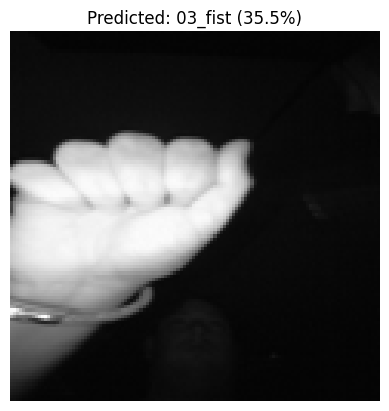

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random, glob

def predict_image(path):
    img = image.load_img(path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, 0)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    pred = model.predict(arr)
    idx = np.argmax(pred[0])
    return class_names[idx], float(pred[0][idx])

# Pick a random test image
sample_path = random.choice(glob.glob('processed_data/test/*/*.png'))
pred_class, confidence = predict_image(sample_path)

# Show result
plt.imshow(Image.open(sample_path))
plt.title(f"Predicted: {pred_class} ({confidence*100:.1f}%)")
plt.axis('off')
plt.show()

